### Testacase Generation Agentic workflow

In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START, END

class TestState(TypedDict):
    description: str
    code: str
    review_done: str
    review_score: str
    testcase_generation: str
    summery: str

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="qwen-2.5-32b")
res = llm.invoke("Hello how are you")
res

AIMessage(content="Hello! As an AI, I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 33, 'total_tokens': 63, 'completion_time': 0.15, 'prompt_time': 0.003963698, 'queue_time': 0.234804438, 'total_time': 0.153963698}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-0e2bac9c-2f9b-446b-bfdb-b09112d82968-0', usage_metadata={'input_tokens': 33, 'output_tokens': 30, 'total_tokens': 63})

In [3]:
#Nodes
def developer(state: TestState):
    "Based on the description added it will generate code."
    print(state['description'])
    res = llm.invoke(f"Generate the python code based on the provided desctipion: {state['description']}")
    print(res.content)
    return {'code':res.content}

def reviewer(state:TestState):
    "Based on the review of code copy the review and score to review socre."
    r1 = llm.invoke(f"based on provided {state['code']} analyze the code and provide the review feedback.\
                provide the score out of 1-10")
    print(r1.content)
    r2 = llm.invoke(f"based on provided {r1.content} only return the value of the score got out of 10, remember just return the score in int")
    print(r2.content)
    return {"review_done":r1.content, "review_score":r2.content}

def check_review(state:TestState):
    print(state['review_score'])
    score=int(state['review_score'])
    if score>=5:
        return "PASS"
    return "FAIL"


def testcase_gen(state:TestState):
    "Based on review it should go to mergeing after final docstring addition"
    m1 = llm.invoke(f"based on provide {state['code']} analyze the code and generate the possible testcase around the the code and execute them\
                    with some examples, and finally give the no of testcase passaed and failed ex: testcases Passed : 3 \n testcase failed: 3")
    print(m1.content)
    return {'testcase_generation':m1.content}

def summery_gen(state: TestState):
    "Based on review and testcases it should generate the report"
    s1 = llm.invoke(f"Based on provided review {state['review_done']} and tescases {state['testcase_generation']} create summary report in markdown format"
                    )
    print(s1.content)
    return {'summery':s1.content}



In [4]:
test_flow = StateGraph(TestState)
#add node
test_flow.add_node("developer",developer)
test_flow.add_node("reviewer", reviewer)
test_flow.add_node("testcase_gen",testcase_gen)
test_flow.add_node("summery_gen",summery_gen)

#add edge
test_flow.add_edge(START,"developer")
test_flow.add_edge("developer","reviewer")
test_flow.add_conditional_edges(
    "reviewer",check_review,{"PASS":"testcase_gen","FAIL":"developer"}
)
test_flow.add_edge("testcase_gen","summery_gen")
test_flow.add_edge("summery_gen",END)

graph = test_flow.compile()



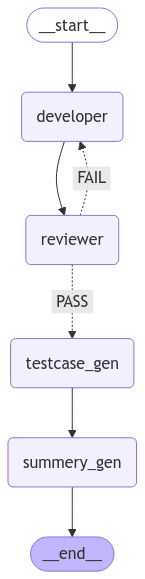

In [5]:
from IPython.display import display,Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
res = graph.invoke({"description":"generate code for happy number"}
                   )
res

generate code for happy number
A happy number is defined by the following process: Starting with any positive integer, replace the number by the sum of the squares of its digits, and repeat the process until the number equals 1 (where it will stay), or it loops endlessly in a cycle which does not include 1. Those numbers for which this process ends in 1 are happy numbers.

Here is a Python function to check if a number is a happy number:

```python
def is_happy_number(n):
    def get_next(number):
        return sum(int(digit) ** 2 for digit in str(number))

    seen = set()
    while n != 1 and n not in seen:
        seen.add(n)
        n = get_next(n)

    return n == 1

# Example usage:
number = 19
print(f'Is {number} a happy number? {is_happy_number(number)}')
```

This function works by repeatedly replacing the number with the sum of the squares of its digits until it either reaches 1 (indicating a happy number) or enters a cycle (indicating it is not a happy number). The `seen` s

{'description': 'generate code for happy number',
 'code': "A happy number is defined by the following process: Starting with any positive integer, replace the number by the sum of the squares of its digits, and repeat the process until the number equals 1 (where it will stay), or it loops endlessly in a cycle which does not include 1. Those numbers for which this process ends in 1 are happy numbers.\n\nHere is a Python function to check if a number is a happy number:\n\n```python\ndef is_happy_number(n):\n    def get_next(number):\n        return sum(int(digit) ** 2 for digit in str(number))\n\n    seen = set()\n    while n != 1 and n not in seen:\n        seen.add(n)\n        n = get_next(n)\n\n    return n == 1\n\n# Example usage:\nnumber = 19\nprint(f'Is {number} a happy number? {is_happy_number(number)}')\n```\n\nThis function works by repeatedly replacing the number with the sum of the squares of its digits until it either reaches 1 (indicating a happy number) or enters a cycle (